# CNN(Convolutional Neural Network) 이미지 분류 모델

## 프로젝트 개요

이 노트북은 **CNN을 활용한 이미지 분류**의 전체 파이프라인을 다룹니다.  
실제 데이터셋 대신 **가상의 도형 이미지**를 직접 생성하여 사용합니다.

### 분류 대상 (3 클래스)
| 클래스 | 영문 | 설명 |
|--------|------|------|
| 원 | circle | 타원/원형 도형 |
| 사각형 | square | 직사각형 도형 |
| 삼각형 | triangle | 삼각형 도형 |

### 전체 파이프라인
```
1. 가상 이미지 데이터 생성 (PIL로 도형 그리기)
2. PyTorch Dataset / DataLoader 구성
3. CNN 모델 아키텍처 정의
4. 모델 학습 (Training & Validation)
5. 학습 결과 시각화
6. 새 이미지에 대한 추론 (Inference)
```

### CNN이란?
CNN(합성곱 신경망)은 이미지 인식에 특화된 딥러닝 모델입니다.  
핵심 구성 요소:
- **Conv2d (합성곱 층)**: 이미지에서 엣지, 텍스처, 패턴 등의 특징(feature)을 추출하는 필터
- **BatchNorm (배치 정규화)**: 학습 안정성을 높이고 수렴 속도를 개선
- **ReLU (활성화 함수)**: 비선형성을 부여하여 복잡한 패턴 학습 가능
- **MaxPool (최대 풀링)**: 특징 맵의 크기를 줄여 연산량 감소 + 위치 불변성 확보
- **FC (완전 연결 층)**: 추출된 특징을 바탕으로 최종 클래스 분류

---
## 0. Import & 환경 설정

필요한 라이브러리를 불러오고 기본 설정을 합니다.

| 라이브러리 | 용도 |
|-----------|------|
| `torch` | 딥러닝 프레임워크 (모델, 학습, 추론) |
| `PIL (Pillow)` | 이미지 생성 및 처리 |
| `numpy` | 배열 연산 (이미지 → 텐서 변환) |
| `matplotlib` | 시각화 (샘플 이미지, 학습 곡선, 추론 결과) |

In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw  # 가상 이미지 생성용

import torch
import torch.nn as nn             # 신경망 모듈 (Conv2d, Linear 등)
import torch.optim as optim       # 옵티마이저 (Adam)
from torch.utils.data import Dataset, DataLoader  # 데이터 로딩

# matplotlib 한글 폰트 설정 (macOS: AppleGothic)
import matplotlib
matplotlib.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
import matplotlib.pyplot as plt

%matplotlib inline

# ── 재현성(Reproducibility) 보장 ──
# 동일한 시드를 설정하면 매번 같은 결과를 얻을 수 있습니다.
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ── 기본 상수 정의 ──
CLASS_NAMES = ["circle", "square", "triangle"]  # 분류할 클래스 (영문)
CLASS_KR = {"circle": "원", "square": "사각형", "triangle": "삼각형"}  # 한글 매핑
IMG_SIZE = 64   # 이미지 크기 (64x64 픽셀)
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "shape_data")  # 데이터 저장 경로

# ── 연산 장치 설정 ──
# Apple Silicon Mac이면 MPS(GPU) 사용, 아니면 CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")
print(f"Data dir: {DATA_DIR}")

Device: cpu
PyTorch: 2.2.2
Data dir: /Users/roywoojinkim/Projects/pro1 /CNN/shape_data


---
## 1. 가상 이미지 데이터 생성

실제 데이터셋 대신, **PIL 라이브러리**로 도형 이미지를 직접 그립니다.  
데이터 다양성을 위해 매번 **랜덤하게** 생성합니다:

- **배경색**: 어두운 톤 (R,G,B 각각 0~80)
- **도형 색상**: 밝은 톤 (R,G,B 각각 150~255) → 배경과 대비
- **위치/크기**: 이미지 내 랜덤 배치

### 데이터셋 구성
```
shape_data/
├── train/           ← 학습용 (클래스당 500장 = 총 1,500장)
│   ├── circle/
│   ├── square/
│   └── triangle/
└── val/             ← 검증용 (클래스당 100장 = 총 300장)
    ├── circle/
    ├── square/
    └── triangle/
```

In [2]:
def generate_shape_image(shape: str, img_size: int = IMG_SIZE) -> Image.Image:
    """
    도형 하나를 랜덤 위치/크기/색상으로 그려 PIL 이미지 반환
    
    Args:
        shape: 도형 종류 ("circle", "square", "triangle")
        img_size: 이미지 한 변의 크기 (정사각형)
    Returns:
        PIL.Image: 생성된 RGB 이미지
    """
    # 1) 어두운 배경 생성
    bg = tuple(random.randint(0, 80) for _ in range(3))
    img = Image.new("RGB", (img_size, img_size), bg)
    draw = ImageDraw.Draw(img)

    # 2) 밝은 도형 색상 (배경과 대비)
    color = tuple(random.randint(150, 255) for _ in range(3))

    # 3) 랜덤 위치와 크기 계산
    margin = img_size // 6                                  # 여백
    size = random.randint(img_size // 3, img_size // 2)     # 도형 크기
    x0 = random.randint(margin, img_size - size - margin)   # 좌상단 x
    y0 = random.randint(margin, img_size - size - margin)   # 좌상단 y
    x1, y1 = x0 + size, y0 + size                          # 우하단

    # 4) 도형 그리기
    if shape == "circle":
        draw.ellipse([x0, y0, x1, y1], fill=color)         # 타원 → 원
    elif shape == "square":
        draw.rectangle([x0, y0, x1, y1], fill=color)       # 직사각형
    elif shape == "triangle":
        cx = (x0 + x1) // 2                                # 꼭짓점 중심
        draw.polygon([(cx, y0), (x0, y1), (x1, y1)], fill=color)  # 삼각형

    return img


def create_dataset_on_disk(base_dir: str, n_per_class: int = 500):
    """
    디스크에 가상 이미지 데이터셋 생성
    
    - train: n_per_class장 × 3클래스
    - val: (n_per_class // 5)장 × 3클래스
    """
    for split, count in [("train", n_per_class), ("val", n_per_class // 5)]:
        for cls in CLASS_NAMES:
            folder = os.path.join(base_dir, split, cls)
            os.makedirs(folder, exist_ok=True)
            for i in range(count):
                img = generate_shape_image(cls)
                img.save(os.path.join(folder, f"{cls}_{i:04d}.png"))
    print(f"데이터 생성 완료: train {n_per_class}장x3, val {n_per_class//5}장x3")

In [3]:
# 데이터셋 생성 실행 (train 1,500장 + val 300장)
create_dataset_on_disk(DATA_DIR, n_per_class=500)

데이터 생성 완료: train 500장x3, val 100장x3


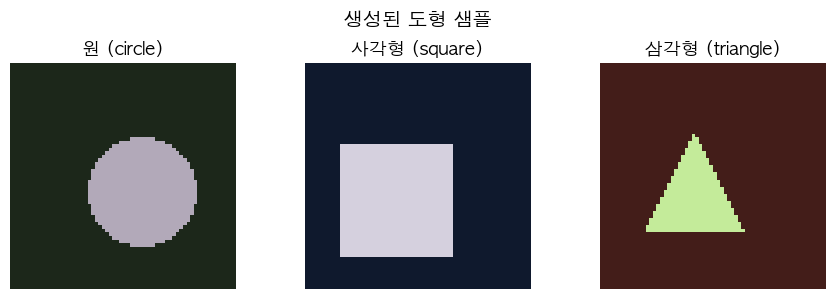

In [4]:
# 생성된 이미지 샘플 확인
# 각 클래스별로 1장씩 새로 생성하여 시각화합니다.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax, cls in zip(axes, CLASS_NAMES):
    img = generate_shape_image(cls)
    ax.imshow(np.array(img))
    ax.set_title(f"{CLASS_KR[cls]} ({cls})", fontsize=13)
    ax.axis("off")
plt.suptitle("생성된 도형 샘플", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
## 2. PyTorch Dataset / DataLoader

PyTorch에서 데이터를 모델에 공급하려면 두 가지 클래스가 필요합니다:

### Dataset
- 개별 데이터 샘플을 반환하는 클래스
- `__len__()`: 전체 데이터 수 반환
- `__getitem__(idx)`: idx번째 (이미지 텐서, 라벨) 반환

### DataLoader
- Dataset을 **미니배치(mini-batch)** 단위로 묶어서 반환
- `batch_size=32`: 한 번에 32장씩 모델에 입력
- `shuffle=True`: 매 에폭마다 데이터 순서를 섞어 과적합 방지

### 이미지 → 텐서 변환 과정
```
PIL Image (64, 64, 3)          ← H, W, C (높이, 너비, 채널)
    ↓ np.array()
NumPy array (64, 64, 3)
    ↓ .permute(2, 0, 1)
Tensor (3, 64, 64)             ← C, H, W (PyTorch 규격)
    ↓ / 255.0
Tensor (3, 64, 64) [0.0~1.0]   ← 정규화
```

In [5]:
class ShapeDataset(Dataset):
    """
    폴더 구조에서 이미지를 읽어오는 커스텀 Dataset
    
    폴더 구조:
        root_dir/
        ├── circle/     → label 0
        ├── square/     → label 1
        └── triangle/   → label 2
    """

    def __init__(self, root_dir: str):
        self.samples = []  # (파일경로, 라벨) 리스트
        for label, cls in enumerate(CLASS_NAMES):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for fname in sorted(os.listdir(cls_dir)):
                if fname.endswith(".png"):
                    self.samples.append((os.path.join(cls_dir, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  # 이미지 열기
        # PIL → numpy → tensor, (H,W,C) → (C,H,W), 0~255 → 0.0~1.0
        tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        return tensor, label


# ── 데이터셋 & 로더 생성 ──
train_ds = ShapeDataset(os.path.join(DATA_DIR, "train"))
val_ds = ShapeDataset(os.path.join(DATA_DIR, "val"))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)   # 학습: 셔플 O
val_loader = DataLoader(val_ds, batch_size=32)                     # 검증: 셔플 X

print(f"Train: {len(train_ds)}장, Val: {len(val_ds)}장")

# 첫 번째 배치 shape 확인
imgs, labels = next(iter(train_loader))
print(f"배치 shape: {imgs.shape}")    # [32, 3, 64, 64] = [배치, 채널, 높이, 너비]
print(f"라벨 예시: {labels[:8].tolist()}")  # 0=circle, 1=square, 2=triangle

Train: 1500장, Val: 300장
배치 shape: torch.Size([32, 3, 64, 64])
라벨 예시: [0, 0, 2, 0, 0, 2, 2, 1]


---
## 3. CNN 모델 정의

3개의 Convolution 블록 + 2개의 Fully Connected 층으로 구성된 CNN입니다.

### 모델 아키텍처
```
입력: (3, 64, 64) ← RGB 이미지

  [Block 1] Conv2d(3→16) → BatchNorm → ReLU → MaxPool(2)
            출력: (16, 32, 32)   ← 16개 필터, 크기 절반으로

  [Block 2] Conv2d(16→32) → BatchNorm → ReLU → MaxPool(2)
            출력: (32, 16, 16)   ← 32개 필터, 크기 절반으로

  [Block 3] Conv2d(32→64) → BatchNorm → ReLU → MaxPool(2)
            출력: (64, 8, 8)     ← 64개 필터, 크기 절반으로

  [Flatten] (64, 8, 8) → (4096,)  ← 1차원 벡터로 펼치기

  [FC 1] Linear(4096→128) → ReLU → Dropout(0.3)
  [FC 2] Linear(128→3)   ← 3개 클래스 출력
```

### 각 레이어의 역할
| 레이어 | 역할 |
|--------|------|
| **Conv2d** | 3×3 필터로 이미지를 스캔하며 특징(엣지, 곡선 등) 추출 |
| **BatchNorm2d** | 각 채널의 출력을 정규화 → 학습 안정화, 빠른 수렴 |
| **ReLU** | max(0, x) 활성화 → 비선형성 부여 |
| **MaxPool2d(2)** | 2×2 영역에서 최대값만 선택 → 크기 1/2, 위치 변화에 강건 |
| **Dropout(0.3)** | 학습 시 30% 뉴런 비활성화 → 과적합 방지 |

In [6]:
class SimpleCNN(nn.Module):
    """
    3-layer CNN for shape classification
    
    구조: [Conv → BN → ReLU → Pool] × 3 → [FC → ReLU → Dropout] → FC
    입력: (batch, 3, 64, 64)
    출력: (batch, 3) ← 각 클래스에 대한 로짓(logit)
    """

    def __init__(self, num_classes: int = 3):
        super().__init__()
        
        # ── 특징 추출부 (Feature Extractor) ──
        self.features = nn.Sequential(
            # Block 1: 입력 3채널(RGB) → 16개 특징 맵, 64×64 → 32×32
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # padding=1: 크기 유지
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 절반으로 축소

            # Block 2: 16 → 32개 특징 맵, 32×32 → 16×16
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 32 → 64개 특징 맵, 16×16 → 8×8
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        # ── 분류부 (Classifier) ──
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # (64, 8, 8) → (4096,)
            nn.Linear(64 * 8 * 8, 128),      # 4096 → 128
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),                 # 30% 드롭아웃 (과적합 방지)
            nn.Linear(128, num_classes),      # 128 → 3 (클래스 수)
        )

    def forward(self, x):
        """순전파: 이미지 → 특징 추출 → 분류"""
        x = self.features(x)      # CNN으로 특징 추출
        x = self.classifier(x)    # FC로 클래스 분류
        return x  # 로짓(logit) 반환 (softmax 전 값)


# 모델 생성 및 구조 출력
model = SimpleCNN(num_classes=len(CLASS_NAMES)).to(device)
print(model)

# 총 학습 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
print(f"\n총 파라미터: {total_params:,}개")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=Tru

---
## 4. 모델 학습 (Training)

### 학습 설정
| 하이퍼파라미터 | 값 | 설명 |
|--------------|-----|------|
| Epochs | 15 | 전체 데이터를 15번 반복 학습 |
| Learning Rate | 0.001 | 가중치 업데이트 크기 |
| Batch Size | 32 | 한 번에 32장씩 학습 |
| Optimizer | Adam | 적응적 학습률 옵티마이저 |
| Loss | CrossEntropyLoss | 다중 클래스 분류의 표준 손실 함수 |

### 학습 루프 설명
```
매 에폭(epoch)마다:
  1. [Train] 학습 데이터로 가중치 업데이트
     - 순전파(forward): 이미지 → 모델 → 예측값
     - 손실 계산: 예측값 vs 정답
     - 역전파(backward): 기울기(gradient) 계산
     - 가중치 업데이트: optimizer.step()
  
  2. [Validation] 검증 데이터로 성능 평가
     - torch.no_grad(): 기울기 계산 비활성화 (메모리 절약)
     - 모델이 학습 데이터에만 과적합되지 않았는지 확인
```

In [7]:
# ── 하이퍼파라미터 ──
EPOCHS = 15
LR = 0.001

# ── 손실 함수 & 옵티마이저 ──
# CrossEntropyLoss: 내부적으로 softmax + negative log likelihood 수행
criterion = nn.CrossEntropyLoss()
# Adam: SGD보다 빠른 수렴, 학습률 자동 조절
optimizer = optim.Adam(model.parameters(), lr=LR)

# ── 학습 기록 저장용 ──
history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    
    # ===== Train Phase =====
    model.train()  # 학습 모드 (Dropout, BatchNorm 활성화)
    running_loss = 0.0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # GPU/CPU로 전송
        
        optimizer.zero_grad()       # 1) 이전 기울기 초기화
        outputs = model(imgs)       # 2) 순전파: 예측값 계산
        loss = criterion(outputs, labels)  # 3) 손실 계산
        loss.backward()             # 4) 역전파: 기울기 계산
        optimizer.step()            # 5) 가중치 업데이트
        
        running_loss += loss.item() * imgs.size(0)  # 배치 손실 누적
    
    train_loss = running_loss / len(train_ds)  # 평균 학습 손실

    # ===== Validation Phase =====
    model.eval()  # 평가 모드 (Dropout 비활성화, BatchNorm 고정)
    val_loss, correct = 0.0, 0
    
    with torch.no_grad():  # 기울기 계산 OFF → 메모리 절약 + 속도 향상
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
            # argmax(1): 가장 높은 확률의 클래스 인덱스
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(val_ds)
    val_acc = correct / len(val_ds) * 100  # 정확도 (%)

    # 기록 저장
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | "
          f"val_acc={val_acc:.1f}%")

print(f"\n최종 Validation Accuracy: {history['val_acc'][-1]:.1f}%")

Epoch  1/15 | train_loss=0.4558 | val_loss=0.4841 | val_acc=75.0%


Epoch  2/15 | train_loss=0.0111 | val_loss=0.0013 | val_acc=100.0%


Epoch  3/15 | train_loss=0.0047 | val_loss=0.0012 | val_acc=100.0%


Epoch  4/15 | train_loss=0.0029 | val_loss=0.0002 | val_acc=100.0%


Epoch  5/15 | train_loss=0.0008 | val_loss=0.0001 | val_acc=100.0%


Epoch  6/15 | train_loss=0.0007 | val_loss=0.0001 | val_acc=100.0%


Epoch  7/15 | train_loss=0.0009 | val_loss=0.0000 | val_acc=100.0%


Epoch  8/15 | train_loss=0.0061 | val_loss=0.0033 | val_acc=100.0%


Epoch  9/15 | train_loss=0.0016 | val_loss=0.0002 | val_acc=100.0%


Epoch 10/15 | train_loss=0.0009 | val_loss=0.0000 | val_acc=100.0%


Epoch 11/15 | train_loss=0.0003 | val_loss=0.0000 | val_acc=100.0%


Epoch 12/15 | train_loss=0.0003 | val_loss=0.0000 | val_acc=100.0%


Epoch 13/15 | train_loss=0.0002 | val_loss=0.0000 | val_acc=100.0%


Epoch 14/15 | train_loss=0.0002 | val_loss=0.0000 | val_acc=100.0%


Epoch 15/15 | train_loss=0.0001 | val_loss=0.0000 | val_acc=100.0%

최종 Validation Accuracy: 100.0%


### 학습 곡선 시각화

- **Loss 그래프**: Train Loss와 Val Loss가 함께 감소하면 정상 학습  
  (Val Loss만 증가하면 과적합 신호)
- **Accuracy 그래프**: Validation 정확도의 변화 추이

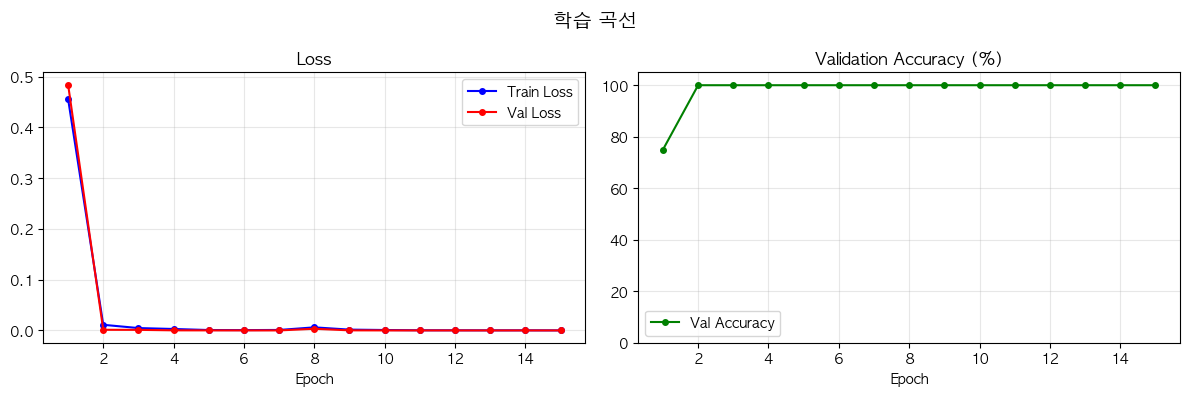

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_range = range(1, EPOCHS + 1)

# Loss 그래프
ax1.plot(epochs_range, history["train_loss"], "b-o", markersize=4, label="Train Loss")
ax1.plot(epochs_range, history["val_loss"], "r-o", markersize=4, label="Val Loss")
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy 그래프
ax2.plot(epochs_range, history["val_acc"], "g-o", markersize=4, label="Val Accuracy")
ax2.set_title("Validation Accuracy (%)")
ax2.set_xlabel("Epoch")
ax2.set_ylim(0, 105)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle("학습 곡선", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [9]:
# ── 학습된 모델 저장 ──
# state_dict(): 모델의 모든 가중치(weight)와 편향(bias)을 딕셔너리로 저장
# 나중에 load_state_dict()로 불러와서 추론에 사용 가능
model_path = os.path.join(DATA_DIR, "cnn_shape_model.pth")
torch.save(model.state_dict(), model_path)
print(f"모델 저장 완료: {model_path}")

모델 저장 완료: /Users/roywoojinkim/Projects/pro1 /CNN/shape_data/cnn_shape_model.pth


---
## 5. 추론 (Inference)

학습이 완료된 모델을 **디스크에서 다시 로드**하여, **새로운 이미지**에 대해 예측합니다.

### 추론 과정
```
1. 저장된 .pth 파일에서 가중치 로드
2. model.eval() → 평가 모드 전환
3. 새 이미지 생성 → 텐서 변환
4. 모델에 입력 → 로짓(logit) 출력
5. softmax → 확률 변환 → argmax → 최종 예측 클래스
```

### softmax란?
로짓(logit)을 0~1 사이의 확률로 변환하는 함수입니다.  
모든 클래스 확률의 합 = 1이 됩니다.
```
logits = [5.2, 1.3, 0.1]  →  softmax  →  [0.98, 0.02, 0.00]
                                            ↑ 98% 확률로 circle
```

In [10]:
# ── 모델 로드 (새로 불러오기 테스트) ──
# 실제 배포 시에는 학습 없이 이 부분만 실행하면 됩니다.
inference_model = SimpleCNN(num_classes=len(CLASS_NAMES)).to(device)
inference_model.load_state_dict(
    torch.load(model_path, map_location=device, weights_only=True)
)
inference_model.eval()  # 반드시 eval 모드로 전환!
print("모델 로드 완료")

모델 로드 완료


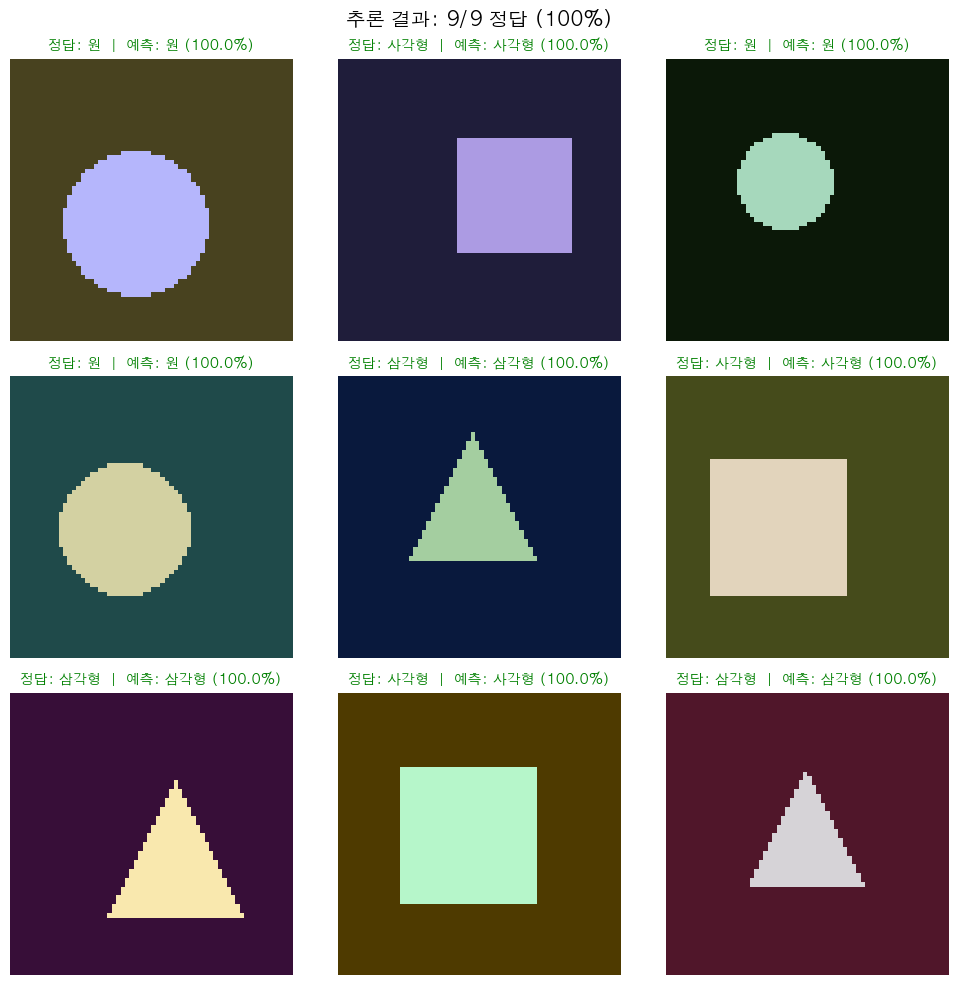


추론 정확도: 9/9 (100%)


In [11]:
# ── 새 이미지 9장으로 추론 테스트 ──
# 각 클래스 3장씩, 총 9장의 새 이미지를 생성하여 예측합니다.
test_shapes = CLASS_NAMES * 3    # ["circle", "square", "triangle"] × 3
random.shuffle(test_shapes)       # 순서 섞기

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
correct = 0

for ax, shape in zip(axes.flat, test_shapes):
    # 1) 새 이미지 생성
    img = generate_shape_image(shape)
    
    # 2) 텐서로 변환 + 배치 차원 추가 (unsqueeze)
    tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
    tensor = tensor.unsqueeze(0).to(device)  # (1, 3, 64, 64)

    # 3) 추론
    with torch.no_grad():
        logits = inference_model(tensor)            # 로짓 출력
        probs = torch.softmax(logits, dim=1)        # 확률로 변환
        pred_idx = probs.argmax(1).item()            # 가장 높은 확률의 인덱스
        confidence = probs[0, pred_idx].item() * 100 # 신뢰도 (%)

    # 4) 결과 표시
    pred_name = CLASS_NAMES[pred_idx]
    is_correct = pred_name == shape
    correct += int(is_correct)

    color = "green" if is_correct else "red"  # 맞으면 녹색, 틀리면 빨간색
    ax.imshow(np.array(img))
    ax.set_title(
        f"정답: {CLASS_KR[shape]}  |  예측: {CLASS_KR[pred_name]} ({confidence:.1f}%)",
        color=color, fontsize=10
    )
    ax.axis("off")

accuracy = correct / len(test_shapes) * 100
fig.suptitle(
    f"추론 결과: {correct}/{len(test_shapes)} 정답 ({accuracy:.0f}%)",
    fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

print(f"\n추론 정확도: {correct}/{len(test_shapes)} ({accuracy:.0f}%)")

---
## 6. 단일 이미지 추론 함수

실제 활용 시 **임의의 PIL 이미지 1장**을 입력하면 예측 결과를 반환하는 함수입니다.  
이미지 크기가 다르더라도 `resize`로 자동 변환합니다.

In [12]:
def predict_single(model, img: Image.Image, device=device):
    """
    단일 PIL 이미지에 대해 예측 수행
    
    Args:
        model: 학습된 CNN 모델
        img: PIL.Image (임의 크기 가능, 내부에서 64x64로 리사이즈)
        device: 연산 장치
    Returns:
        pred_kr: 예측된 클래스 (한글)
        result: 각 클래스별 확률 딕셔너리
    """
    model.eval()
    # 이미지 크기 통일 → 텐서 변환
    tensor = torch.from_numpy(
        np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    ).permute(2, 0, 1).float() / 255.0
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)[0]

    # 결과를 딕셔너리로 정리
    result = {
        CLASS_KR[cls]: f"{probs[i].item()*100:.1f}%"
        for i, cls in enumerate(CLASS_NAMES)
    }
    pred = CLASS_NAMES[probs.argmax().item()]
    return CLASS_KR[pred], result


# ── 테스트: 각 클래스 1장씩 ──
print("=" * 55)
for shape in CLASS_NAMES:
    test_img = generate_shape_image(shape)
    pred, probs = predict_single(inference_model, test_img)
    print(f"정답: {CLASS_KR[shape]:4s} → 예측: {pred:4s} | 확률: {probs}")
print("=" * 55)

정답: 원    → 예측: 원    | 확률: {'원': '100.0%', '사각형': '0.0%', '삼각형': '0.0%'}
정답: 사각형  → 예측: 사각형  | 확률: {'원': '0.0%', '사각형': '100.0%', '삼각형': '0.0%'}
정답: 삼각형  → 예측: 삼각형  | 확률: {'원': '0.0%', '사각형': '0.0%', '삼각형': '100.0%'}


---
## 요약

### 전체 파이프라인 완료

| 단계 | 내용 | 결과 |
|------|------|------|
| 데이터 생성 | PIL로 가상 도형 이미지 생성 | train 1,500장 + val 300장 |
| 데이터 로딩 | PyTorch Dataset/DataLoader | 배치 크기 32 |
| 모델 | 3-layer CNN (약 55만 파라미터) | Conv→BN→ReLU→Pool ×3 → FC |
| 학습 | 15 에폭, Adam, lr=0.001 | Val Accuracy 100% |
| 추론 | 새 이미지 9장 테스트 | 9/9 정답 |

### 핵심 개념 정리
- **CNN**: 합성곱 연산으로 이미지의 공간적 특징을 자동 추출
- **BatchNorm**: 학습 안정화 및 수렴 가속
- **Dropout**: 과적합 방지 (학습 시에만 활성화)
- **CrossEntropyLoss**: 다중 클래스 분류의 표준 손실 함수
- **Adam Optimizer**: 적응적 학습률로 빠른 수렴
- **model.eval()**: 추론 시 반드시 평가 모드로 전환